# 8. Clustering
## K-means clustering

What if we do not have any training data? Unsupervised approach - k-means clustering can help learning the most suitable cluster structure given a suggested number of clusters $k$. 

Works for the data samples ($N$ points) in $n$-dimensional Euclidean space: 
$$
X=\{x_i, i=1..N\}=\{x_i^j, i=1..N, j=1..n\},
$$ 
where $x_i$ are the $n$-dimensional raw-vectors corresponding to each of the $N$ sample points. The approach is trying to infer cluster indexes $c_i$ (taking one of the possible values $1,2,...,k$) for each point $x_i$ in such a way that the cumulative squared distance from all the sample points $x_i$ to the centroids $\mu_{c_i}$ of the corresponding clusters $c_i$ is minimized. This is quite an intuitive criteria, meaning that the clusters as as compact as possible for the given number $k$. The cluster centroids are defined as simple vector means
$$
\mu_c=\sum_{i, c(i)=c} x_i/m(c),
$$
where
$$
m(c)=|\{i, c(i)=c\}|
$$
denotes the cluster size. Or in the coordinate form $\mu_c=(\mu_c^j, j=1..n)$
$$
\mu_c^j=\frac{\sum_{i, c(i)=c} x_i^j}{m(c)}, j=1..n.
$$
Then the mimimal cumulatize squared distance criteria can be written as
$$
SD=\sum_i \|x_i-\mu_{c_i}\|^2=\sum_{i,j} \left(x_i^j-\mu_{c_i}^j\right)^2\to \min
$$

The common algorithm (often called after Lloyd) starts from a random cluster assignment and iterates the following two steps:

A. Compute cluster means.

B. Re-assign each point to the cluster with the mean closest to the considered point.

Alternative approach is to initially use $k$ random points of the sample as clusters means, starting from the step B.

The algorithm stops once a new iteration fails to alter any single cluster assignment.

Algorithm always converges to a local optimum of $SD$, however there is no guarantee that this partitioning is indeed the global optimum. Also the final outcome happens to depend on the initial partitioning. This way it makes sense to repreat $k$-means a number of times (like $10,25...100$ etc) with different random initial partitioning, picking up the partitioning with the best final $SD$. 

In order to figure out how many trials to consider one can keep adding them one by one tracking how do they affect the final score and stop once it stays stable for a while.


### Toy Example. 

In [1]:
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from matplotlib.pylab import plt
import numpy as np
%matplotlib inline

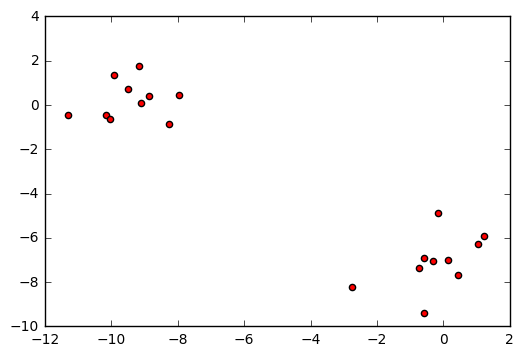

In [2]:
X, y = make_blobs(n_features=2, centers=2,n_samples=20,random_state=9)
plt.scatter(X[:,0],X[:,1],c="r")
plt.show()

#### If we calculate by hand for this simple example, we do this:

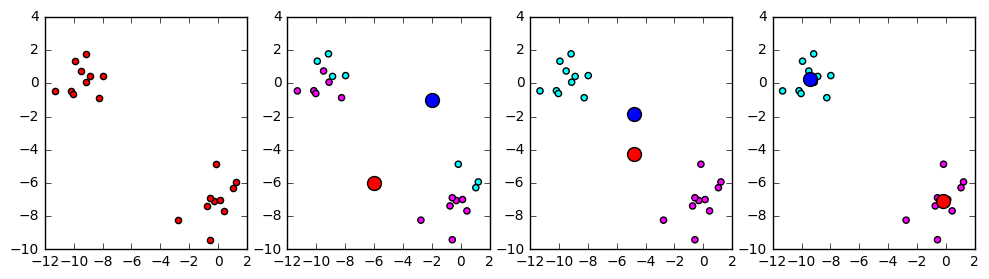

In [3]:
cent=np.asarray([[-6,-6],[-2,-1]])
plt.figure(figsize=(12,3))
plt.subplot(1,4,1)
plt.scatter(X[:,0],X[:,1],c="r")
for i in range(3):
    plt.subplot(1,4,i+2)
    y_t=np.sum((X-cent[0,:])**2,axis=1)**0.5<np.sum((X-cent[1,:])**2,axis=1)**0.5
    plt.scatter(X[:,0],X[:,1],c=y_t,cmap=plt.cm.cool)
    plt.scatter(cent[0,0],cent[0,1],c="r",s=100)
    plt.scatter(cent[1,0],cent[1,1],c="b",s=100)

    cent=np.asarray([[np.sum(X[:,0]*y_t)/(np.sum(y_t)),np.sum(X[:,1]*y_t)/np.sum(y_t)],
            [np.sum(X[:,0]*(1-y_t))/np.sum(1-y_t),np.sum(X[:,1]*(1-y_t))/np.sum(1-y_t)]])
plt.show()

### Example 2: Kmeans package from sklearn

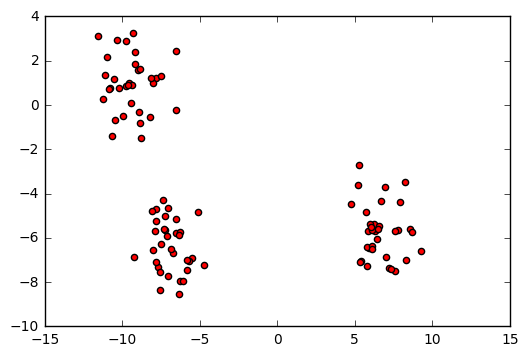

In [4]:
X, y = make_blobs(n_features=2, centers=3,random_state=9999)
plt.scatter(X[:,0],X[:,1],c="r")
plt.show()

In [5]:
#Use package from sklearn.
from sklearn.cluster import KMeans

n=2 # number of clusters
dd=X #data
tar=y # real target

#train the model.
km=KMeans(random_state=324,n_clusters=n)
res=km.fit(dd)
#result.
print(res.labels_)
# print res.predict(dd)

[0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 1
 0 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0
 1 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1]


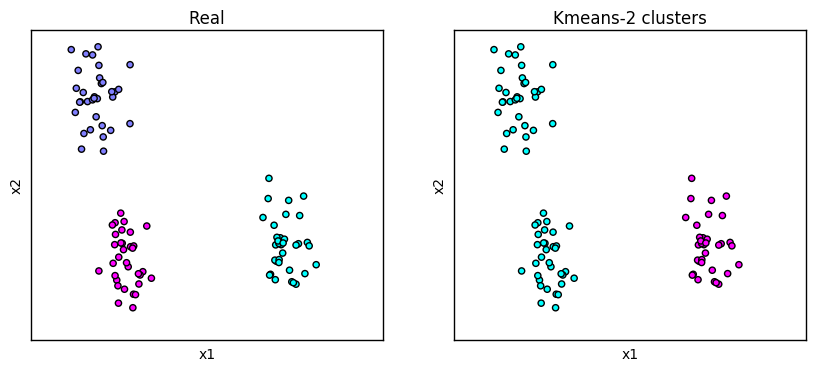

In [6]:
#Plot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)

plt.scatter(dd[:, 0], dd[:, 1], c=tar, cmap=plt.cm.cool)
plt.xlabel('x1')
plt.ylabel('x2')
plt.xticks(())
plt.yticks(())
plt.title("Real")

plt.subplot(1,2,2)
plt.scatter(dd[:, 0], dd[:, 1], c=res.labels_, cmap=plt.cm.cool)
plt.xlabel('x1')
plt.ylabel('x2')
plt.xticks(())
plt.yticks(())
plt.title("Kmeans-{} clusters".format(n))
plt.show()

### Maybe k=3 is more appropriate?

### *Choose the number of clusters. (k)

#### Silhouette Coefficient
In the example above we visually see that the data could still be clustered further. So how to select the appropriate number of clusters $k$ besides just naive visual observations? 

We can't use SD here anymore as the more clusters we take, the smaller it goes, and we'll get it down to zero, assigning each point to its own cluster, which is certianly not the most useful way of clustering.

We need another partitioning quality measure here. Most common option is using a Silhouette measure, which for each data point $x_i$ quantifies its relative attachement strength to its current cluster vs the closest neighbor cluster:
$$
s(i)=\frac{\min\limits_{k\neq c_i} \|x_i-\mu_{c_k}\|-\|x_i-\mu_{c_i}\|}{\max\{\|x_i-\mu_{c_i}\|,\min\limits_{k\neq c_i} \|x_i-\mu_{c_k}\|\}}.
$$

Then internal quality of the partitioning is characterized by an average ratio value of silhouette for all the data points:
$$
S=\frac{\sum\limits_i s(i)}{N}.
$$

By definition, the silhouette measure is normalized. i.e. $-1\leq s(i)\leq 1$ and so is the average: $-1\leq S\leq 1$. $S=1$ means that all the points coinside with their cluster centroids, values close to 1 mean that the points are usually much closer to their cluster centroids than to all the other ones (i.e. clustered appropriately), values of $S$ around zero mean that clustering is quite unstable, i.e. moving many of the points to another clusters might not affect its quality much; while negative values of $S$ mean that clustering could certainly be improved by moving some of the points to the other clusters.

In [7]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np

X=X
range_n_clusters = [2, 3, 4, 5]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.736873485729
For n_clusters =3, the average silhouette_score is :0.767193925494
For n_clusters =4, the average silhouette_score is :0.634941104496
For n_clusters =5, the average silhouette_score is :0.532017164392


#### From the result of silhouette_score, we should choose k=3. Let's see the plot.  s for each observation for each cluster.

In [8]:
def silhouette_score_plot(data,range_n_clusters):
    X=data
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(10, 5)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=324)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)

        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors)

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1],
                    marker='o', c="white", alpha=1, s=200)

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()

('For n_clusters =', 2, 'The average silhouette_score is :', 0.73687348572926747)


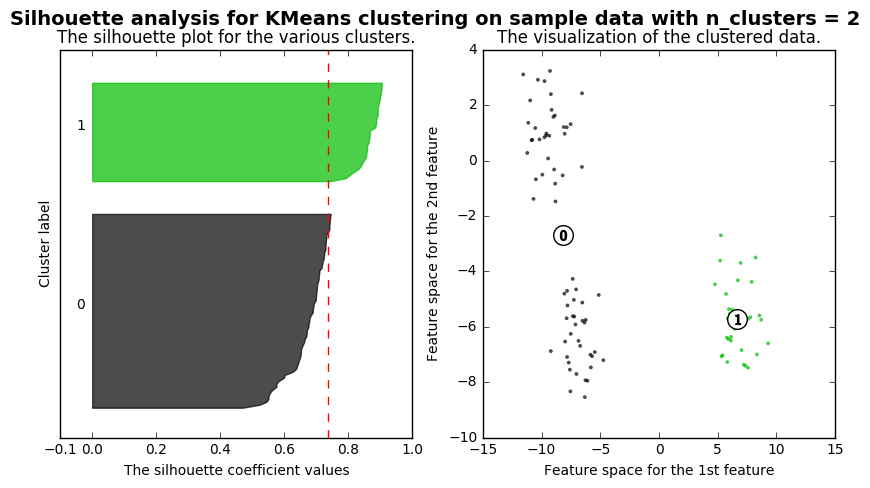

('For n_clusters =', 3, 'The average silhouette_score is :', 0.76719392549425225)


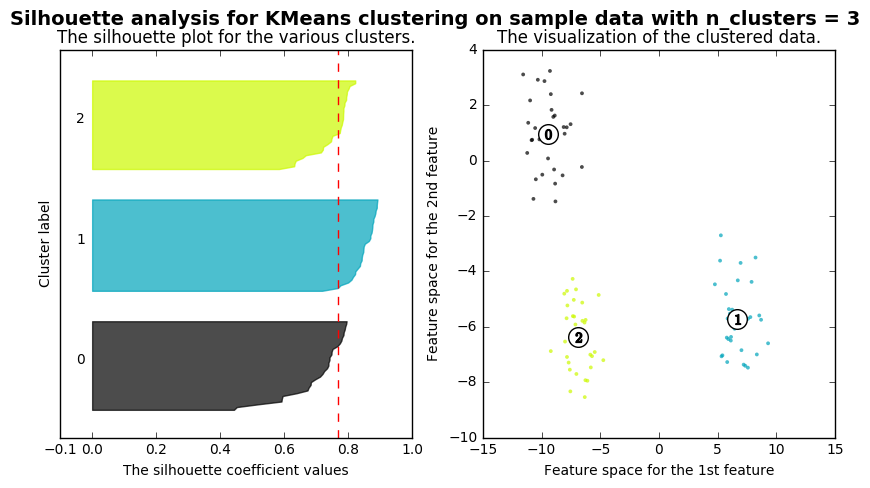

('For n_clusters =', 4, 'The average silhouette_score is :', 0.63494110449581276)


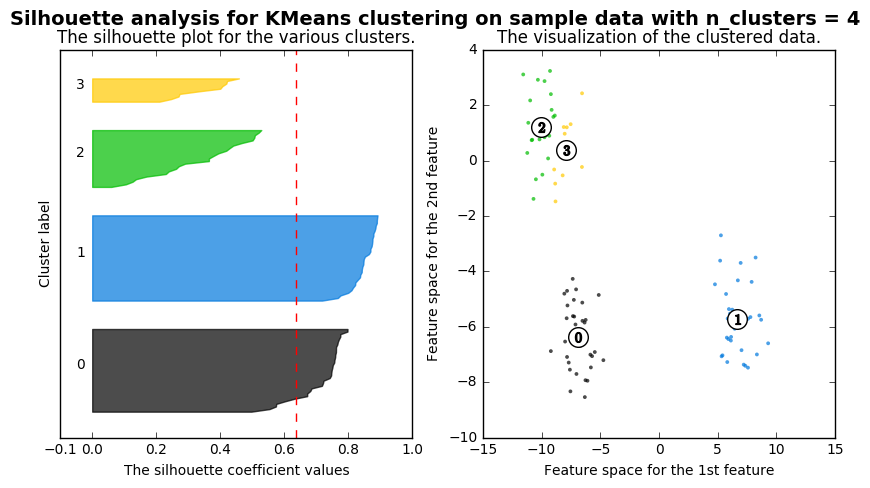

('For n_clusters =', 5, 'The average silhouette_score is :', 0.53201716439225855)


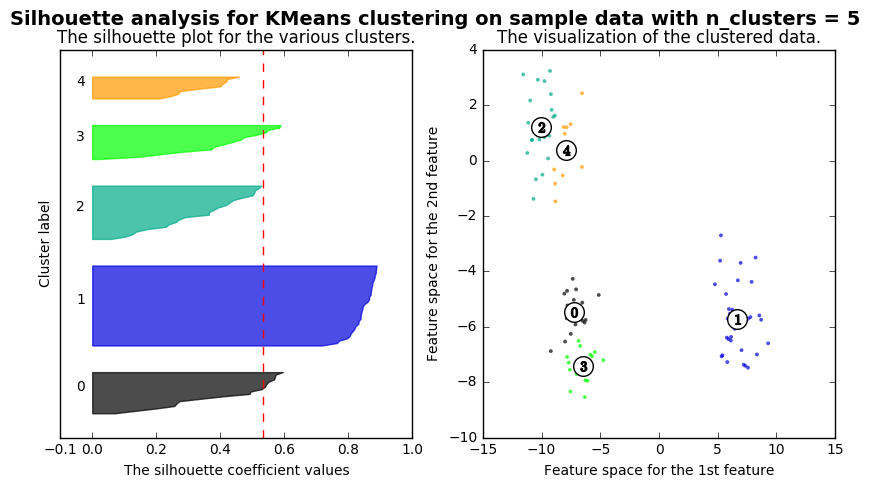

In [9]:
#plot
silhouette_score_plot(X,range(2,6))

### Elbow Method
The Elbow method looks at the percentage of variance explained as a function of the number of clusters: One should choose a number of clusters so that adding another cluster doesn't give much better modeling of the data. More precisely, if one plots the percentage of variance explained by the clusters against the number of clusters, the first clusters will add much information (explain a lot of variance), but at some point the marginal gain will drop, giving an angle in the graph. The number of clusters is chosen at this point, hence the "elbow criterion". This "elbow" cannot always be unambiguously identified.

First of all, compute the sum of squared error (SSE) for some values of k (for example 2, 4, 6, 8, etc.). The SSE is defined as the sum of the squared distance between each member of the cluster and its centroid. Mathematically:

$SSE=\sum^K_{i=1} \sum_{x\in c_i} dist(x,c_i)^2$

 If you plot k against the SSE, you will see that the error decreases as k gets larger; this is because when the number of clusters increases, they should be smaller, so distortion is also smaller. The idea of the elbow method is to choose the k at which the SSE decreases abruptly. This produces an "elbow effect" in the graph, as you can see in the following picture:


In [10]:
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans

def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

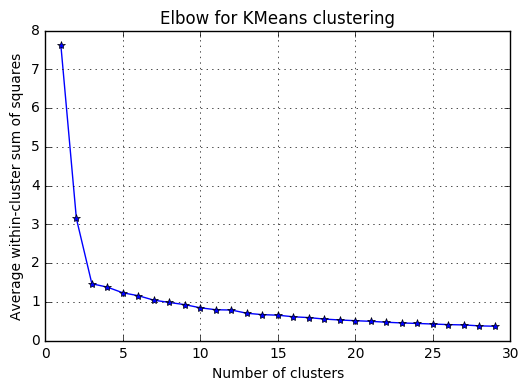

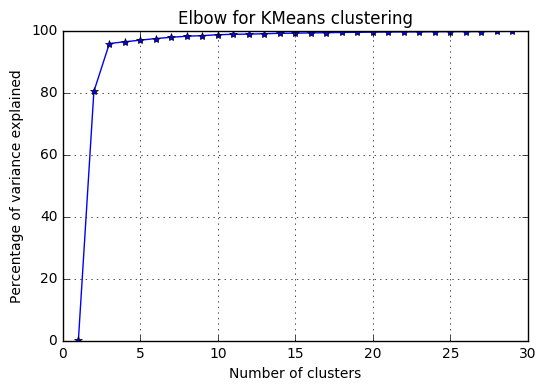

In [11]:
elbow(X, range(1,30))

### Example 3: Guassian Mixture. When KMeans does not work well.

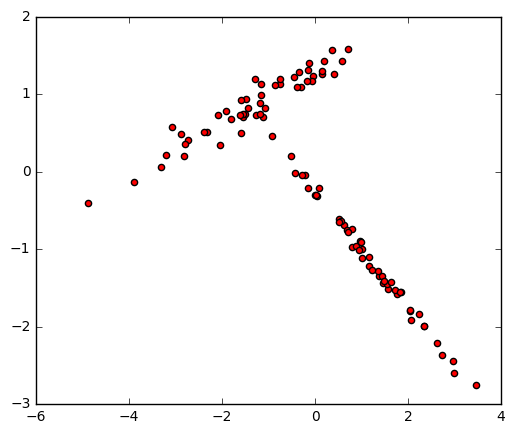

In [12]:
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                             n_clusters_per_class=1,random_state=2)
plt.figure(figsize=(6,5))
plt.scatter(X[:,0],X[:,1],c="r")
plt.show()

In [13]:
# Real vs KMeans vs Guassian Mixture
n=2 # number of clusters
dd=X #data
tar=y # real target

km=KMeans(n_clusters=n)
res=km.fit(dd)
#res.labels_

Make sure that you are using the recent sklearn: 0.18. (The old verison does not work correctly)

If not, please go to the terminal and use the following code to upgrade it.

conda install scikit-learn

In [14]:
# Check Sklearn version.
import sklearn
sklearn.__version__

'0.18'

In [15]:
from sklearn.mixture import GaussianMixture # You can import this only if you are using 0.18+ sklearn.
gm=GaussianMixture(n_components=n,random_state=324)
res1=gm.fit(dd)

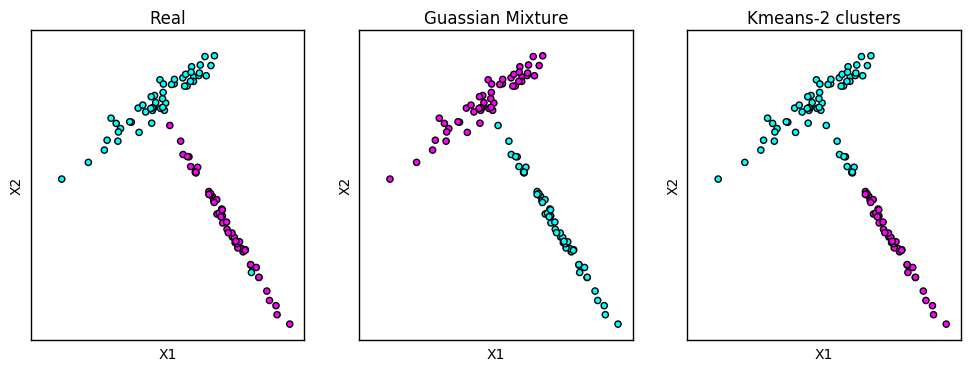

In [16]:
#Plot.
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.scatter(dd[:, 0], dd[:, 1], c=tar, cmap=plt.cm.cool)
plt.xlabel('X1')
plt.ylabel('X2')
plt.xticks(())
plt.yticks(())
plt.title("Real")

plt.subplot(1,3,2)
plt.scatter(dd[:, 0], dd[:, 1], c=res1.predict(dd), cmap=plt.cm.cool)
plt.xlabel('X1')
plt.ylabel('X2')
plt.xticks(())
plt.yticks(())
plt.title("Guassian Mixture")

plt.subplot(1,3,3)
plt.scatter(dd[:, 0], dd[:, 1], c=res.labels_, cmap=plt.cm.cool)
plt.xlabel('X1')
plt.ylabel('X2')
plt.xticks(())
plt.yticks(())
plt.title("Kmeans-{} clusters".format(n))
plt.show()


### Real world example 311 data.

Use Kmeans clustering model to cluster NYC zip codes into FOUR clusters. The feature space is the scaled 311 complaints data (from "Adopt A Basket" to the end. Please do not include "mean" and "sale_price" ) as provided.  Report the number of zip codes in each clusters. 

Visulize the clustering result on the map (For this part we need to use the shapefiles of NY)


In [17]:
#upload previous data we had on 311
data311 = pd.read_csv( 'data/aggr311.csv' , index_col=0 )
data311.head()

,Zip,Complain,Count
1,NaN,Adopt-A-Basket,5
2,10001,Adopt-A-Basket,1
3,10003,Adopt-A-Basket,1
4,10009,Adopt-A-Basket,1
5,10010,Adopt-A-Basket,1


In [18]:
#transform data into matrix
import numbers
zips={}
zipsinv={}
zipnum=0
complains={}
compinv={}
compnum=0
X=np.zeros(shape=(1000,200))
Z=[0]*1000
for i in data311.index:
    z=data311.Zip[i];
    if not isinstance(z, numbers.Number):
      if z.isdigit():
        if (int(z)>10000)& (int(z)<11500):
           if not (z in zips.keys()):
              zips[z]=zipnum
              zipsinv[zipnum]=z
              zipnum+=1
           comp=data311.Complain[i] 
           if not (comp in complains.keys()):
              complains[comp]=compnum
              compinv[compnum]=comp
              compnum+=1
           X[zips[z]][complains[comp]]=data311.Count[i]
           Z[zips[z]]=int(z)
X=X[0:zipnum,0:compnum]
Z=np.array(Z[0:zipnum])

In [19]:
#normalize and filter
sx=np.array([0]*len(Z))
for z in range(0,zipnum):
    sx[z]=sum(X[z,:])
    X[z,:]=X[z,:]/sx[z]
X=X[sx>50,:]
Z=Z[sx>50]    

In [20]:
len(Z)

180

In [21]:
#apply clustering
rr=KMeans(n_clusters=4).fit(pd.DataFrame(X))

In [22]:
#create a dataframe
res=pd.DataFrame({'zipcode':Z, 'label':rr.labels_})

In [23]:
# Q3.
#3.
#import shapefile
import shapefile as shp
from shapely.geometry.polygon import Polygon
from descartes import PolygonPatch

zipsf = shp.Reader('data/NY.shp')
zipsf_records=zipsf.records()
zipsf_shape=zipsf.shapeRecords()

#plot clustering over the map of NYC zip codes
def plot_on_map(result):
    
    x = {}
    for i in range(len(result)):
        key=result.loc[i,'zipcode']
        x[key]=result.loc[i,'label']
    #x is a dictionary (zip codes vs values)
    cmap = plt.cm.spectral(np.linspace(0,1,max(x.values())+2))

    fig = plt.figure(figsize = (12,15)) 
    ax = fig.gca() 
    for s in range(0,len(zipsf_records)):
        z=int(zipsf_records[s][0])
        if z in x.keys(): 
            #from here
            k = x[z] 
            c=cmap[k][0:3]    
            shape=zipsf_shape[s]
            x_ = [i[0] for i in shape.shape.points[:]]
            y_ = [i[1] for i in shape.shape.points[:]]
            poly=Polygon(zip(x_,y_))
            #plt.fill(x,y,color=my_cmap[s])
            ax.add_patch(PolygonPatch(poly, fc=c, ec='k', alpha=0.5, zorder=2 ))

    ax.axis('scaled')
    plt.title("clustering result on map")

    import matplotlib.patches as mpatches
    clum_num=len(result.loc[:,'label'].unique())

    handles=[]
    for t in range(clum_num):
        locals()["patch_{}".format(t)] = mpatches.Patch(color=cmap[t][0:3] , label='cluster'+str(t+1))
        handles.append(locals()["patch_{}".format(t)])

    plt.legend(handles=handles,loc='upper left')
    plt.show()

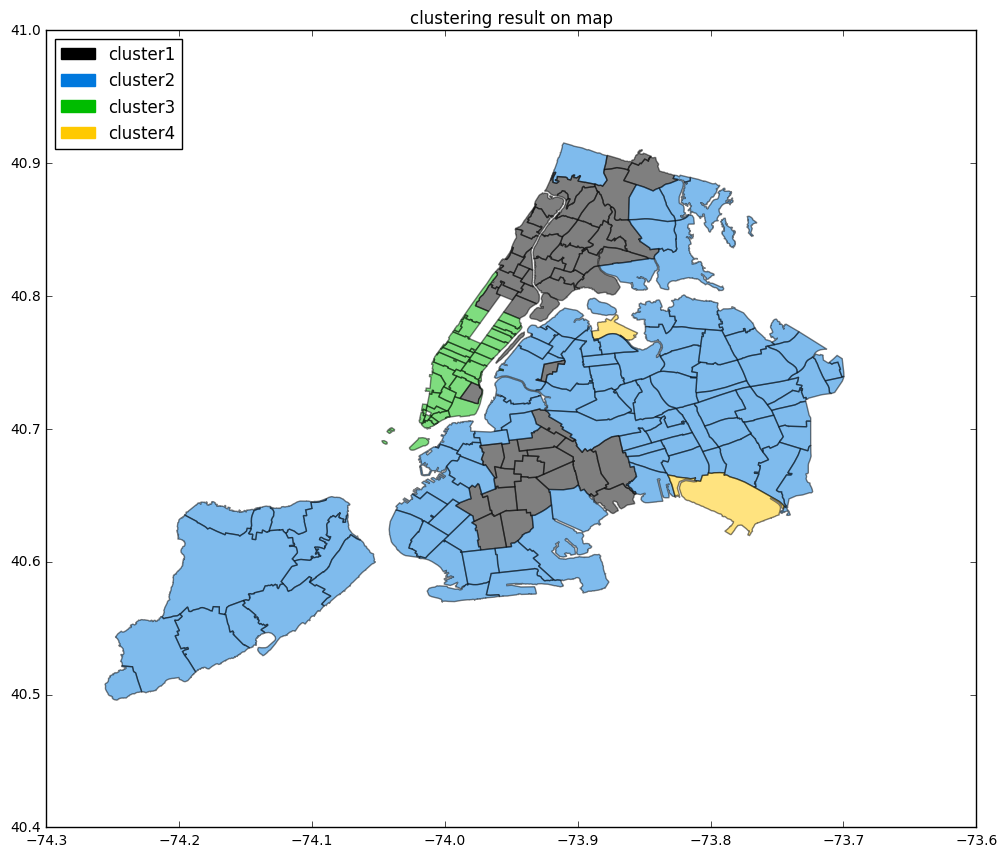

In [24]:
plot_on_map(res)

### Real world exercise. 2012 "stop and frisk" data

https://en.wikipedia.org/wiki/Stop-and-frisk_in_New_York_City

The stop-question-and-frisk program, or stop-and-frisk, in New York City, is a practice of the New York City Police Department in which police officers stop and question a pedestrian, then frisk them for weapons and other contraband; this is what is known in other places in the United States as the Terry stop. The rules for stop, question, and frisk are found in the state's criminal procedure law section 140.50, and are based on the decision of the United States Supreme Court in the case of Terry v. Ohio. About 685,724 people were stopped in 2011. However, the number of stops has been reduced dramatically since then, to 22,939 in 2015.
Stop-and-frisk got increased attention in the 2016 presidential debate.

In [25]:
import pandas as pd
data1=pd.read_csv("data/stop_2012.csv")
# data1=pd.concat((data1.zipcode,data1.iloc[:,:-1]),axis=1)
data1.head()

,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,month_April,month_August,month_December,...,month_November,month_October,month_September,time_1,time_2,time_3,time_4,time_5,time_6,zipcode
0,278.0,212.0,315.0,213.0,254.0,234.0,241.0,158.0,95.0,142.0,...,96.0,110.0,123.0,349.0,35.0,57.0,206.0,437.0,663.0,10472
1,199.0,79.0,301.0,154.0,163.0,137.0,147.0,114.0,114.0,34.0,...,53.0,65.0,96.0,271.0,38.0,32.0,143.0,248.0,448.0,10037
2,278.0,169.0,283.0,203.0,234.0,197.0,289.0,117.0,133.0,91.0,...,86.0,148.0,175.0,462.0,51.0,56.0,190.0,411.0,483.0,10460
3,175.0,82.0,177.0,176.0,180.0,179.0,206.0,112.0,67.0,134.0,...,23.0,68.0,68.0,157.0,27.0,37.0,97.0,282.0,575.0,11224
4,979.0,647.0,1086.0,773.0,913.0,814.0,885.0,709.0,465.0,290.0,...,395.0,521.0,511.0,1295.0,137.0,110.0,662.0,1553.0,2340.0,10456


In [26]:
#Q0. Get the feature space(All the columns except the last one:"zipcode") and save it as a new data set if you want

#Q1. Get the total "stop"s for each zip code using two different timeline scales. (using pd.concate())

#Q2. Find the most "dangerous" zip code by the total "stop"s.

In [27]:
#Now we want to cluster the zip codes by the stops timeline data set. 
#(Don't forget to change your data set to numpy array form)

#Q3.Choosing the number of clusters k for Kmeans. Try both elbow method and silhouette score.

In [28]:
#Q4. Using kmeans to cluster the zip codes.Choose a k as you wish from your elbow and SS result. And save your result as
#the following dataframe/form.

In [29]:
ex=pd.DataFrame([[10472,10037,10460],[0,1,0]]).T
ex.columns=["zipcode",0]
ex

,zipcode,0
0,10472,0
1,10037,1
2,10460,0


In [30]:
#Q5. Visuilize the result on the map by the function above. 

# For this part you need to: 
#(1) Make sure that your result of Q4 is in the correct form.
#(2) Make sure NY.shp, NY.shx, NY.dbf are downloaded in your working directory.
#(3) Use the defined function plot_on_map(your_result)

In [31]:
#Q6. Repeat Q4 and Q5 using Guassian Mixture model.